ENGR190 Final Project  <br> 
Reem Alkhamis and Nico Naar <br> 
nnaar@g.hmc.edu <br> 
ralkhamis@g.hmc.edu <br> 
5/13/2020


# Edge Detection and Keystone Correction 
In this section of the project, we use edge detection on a breadboard image to identify the outline and the corners of the breadboard. We also apply keystone correction on the image in order to correct any optical distortions. We save the corrected images as .npy files, which are used in the following sections of the project. 

In [1]:
import numpy as np
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
from skimage.color import rgb2hsv
from skimage.color import rgb2gray
from scipy import signal
from scipy import ndimage
from operator import itemgetter
from skimage.feature import corner_harris, corner_subpix, corner_peaks
import itertools
from skimage import transform

In [2]:
def gaussian_kernel(size, sigma=1):
    """
        Code found on https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123
        
        Inputs: 
        size = size of kernel
        sigma = std devs 
        
        Outputs: 
        g: a gaussien filter kernel. The image is then convolved with the 
           kernel to smooth/blurr it
    """
    ###
    if (size%2 == 0):
        print('Use odd kernel size for gaussian kernel!!!')
    ###
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal

    return g


In [3]:
def sobel_filters(im):
    
    '''
    Inputs:
    im: image after applying gaussian filter 
    
    Outputs: 
    G: magnitude of the gradient
    theta: slope of the gradient
    
    This fucntion clculates the gradient to detect the edge intensity and direction.   
    '''
    
    kx = np.array([[-1,0,1], [-2,0,2], [-1, 0, 1]], np.float32)
    ky = np.array([[ 1,2,1], [ 0,0,0], [-1,-2,-1]], np.float32)
    
    # in 1d kx = [-1 0 1] bc this gives the change in magnitude across a point
    # Note that slope matrix would be [-1 0 1] * 0.5 but the only thing that 
    # matters is realtive magnitude so we can omit the *0.5
    
    Ix = ndimage.filters.convolve(im, kx)
    Iy = ndimage.filters.convolve(im, ky)
    
    G = np.hypot(Ix, Iy) # takes hypotenuse = element sqrt(Ix, Iy)
    G = G / G.max() * 255 # normalize to 255
    theta = np.arctan2(Iy, Ix)
    
    return G, theta

In [4]:
# Non-max suppression

def non_max_suppression(img, D):
    """
    Inputs: 
    img: output magnitude matrix from filtering step
    D: output phase matrix from filtering step (phase in radians)
    
    Z: the same image with thinner edges
    
    """
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32) # initialization of new image matrix Z
    angle = D * 180. / np.pi
    angle[angle < 0] += 180 #keep angle within +- 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                
                q = 255
                r = 255
                
                # Runs through the phase of each pixel to figure out the direction
                # of the gradient (note that the gradient direction needs to be quantized
                # to 8 posibilities corresposding to the 8 surrounding pixels).
                # After figuring out what direction the quantized gradient is in
                # checks the pixel value in both directions of the gradient (not sure why
                # you can't just check the pixel in the direction of the gradient) and saves the 
                # pixel magnitude value as q & r
                # After all that is computed, the alg. figures out if the original pixel i,j
                # has the largest magnitude value, if it does it sets pixel ij of Z to 
                # pixel ij from the original image magnitude matrix. 
                # if the i,j th element of the original mag matrix is not the largest value, then Z ij = 0
                
                #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]
                
                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

In [5]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    """
    Inputs:
    img: magnitude output from non_max_suppression
    
    Outputs:
    strong: strong pixels that have high intensity that would contribut to
            the final edges
    weak: weak pixels that have low intensity, but not small enough to be 
          considered non-relevant to edge detection
    res: other pixels that are considered non-relevant 
    
    # Double Thresholding find 2 thresholds, choose pixels as strong, weak, not relevant
    """
    # this is a boring way to do it
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    # these values are pretty random
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return res, weak, strong

In [6]:
def hysteresis(img, weak, strong=255):
    """
    Inputs: 
    img: magnitude output from non_max_suppression
    weak: weak pixels that have low intensity, but not small enough to be 
          considered non-relevant to edge detection
          
    Outputs: 
    img: image after transforming weak pixels into strong ones  
    """
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

In [7]:
def pos_pixels(im_mag):
    """
    Inputs: 
    im_mag: the image as a binary image
    
    outputs: 
    pos_pix_pairs: list --> [[i0,j0], [i1,j1], ...] of pixels with magnitude >0
    """
    pos_pix_pairs = [] #list of all pixels that have a mag of 1
    for i in range(im_mag.shape[0]):
        for j in range(im_mag.shape[1]):
            if(im_mag[i,j] > 0):
                pos_pix_pairs.append([i,j])
    return pos_pix_pairs

In [8]:
def find_bread2(im_mag):
    """
    im_mag: binary image
    
    paths: all completed paths found in the image 
    # assumes breadboard edge is not at the edge pixel of the image
    """
    pos_pix_pairs = pos_pixels(im_mag)
    #cont_const - find continuous pixels
    paths = []
    checked_pix = []
    del_pix = 1 # of pixels to check in each direction

    
    for ele in pos_pix_pairs:
        repeat = (ele[0], ele[1]) in checked_pix
        checked_pix.append((ele[0],ele[1]))
        path = []
        nxt = [0,0]
        nxt_ele = ele

        
        if(im_mag[ele[0],ele[1]] == 1):
            while(not repeat):
                nxt_ele = [nxt_ele[0]+nxt[0], nxt_ele[1]+nxt[1]]
                
                # defines nxt transition & a matrix of surrounding values
                surr_elements = im_mag[nxt_ele[0]-del_pix:nxt_ele[0]+del_pix+1, nxt_ele[1]-del_pix:nxt_ele[1]+del_pix+1]   
                path.append((nxt_ele[0], nxt_ele[1]))
                
                # Checks to see if any surrounding elements have mag of 1
                if(np.sum(surr_elements) > 1):
                    
                    # check which surrounding element ahas a magnitude of 1
                    if(im_mag[nxt_ele[0]+1,nxt_ele[1]+0] > 0 and ((nxt_ele[0] + 1, nxt_ele[1] + 0) not in checked_pix)):
                        nxt[0] = 1
                        nxt[1] = 0
                    elif(im_mag[nxt_ele[0]+0,nxt_ele[1]+1] > 0 and ((nxt_ele[0] + 0, nxt_ele[1] + 1) not in checked_pix)):
                        nxt[0] = 0
                        nxt[1] = 1
                    elif(im_mag[nxt_ele[0]-1,nxt_ele[1]+0] > 0 and ((nxt_ele[0] - 1, nxt_ele[1] + 0) not in checked_pix)):
                        nxt[0] =-1
                        nxt[1] = 0 
                    elif(im_mag[nxt_ele[0]+0,nxt_ele[1]-1] > 0 and ((nxt_ele[0] + 0, nxt_ele[1] - 1) not in checked_pix)):
                        nxt[0] = 0
                        nxt[1] =-1    
                    elif(im_mag[nxt_ele[0]+1,nxt_ele[1]+1] > 0 and ((nxt_ele[0] + 1, nxt_ele[1] + 1) not in checked_pix)):
                        nxt[0] = 1
                        nxt[1] = 1
                    elif(im_mag[nxt_ele[0]+1,nxt_ele[1]-1] > 0 and ((nxt_ele[0] + 1, nxt_ele[1] - 1) not in checked_pix)):
                        nxt[0] = 1
                        nxt[1] =-1
                    elif(im_mag[nxt_ele[0]-1,nxt_ele[1]+1] > 0 and ((nxt_ele[0] - 1, nxt_ele[1] + 1) not in checked_pix)):
                        nxt[0] =-1
                        nxt[1] = 1
                    elif(im_mag[nxt_ele[0]-1,nxt_ele[1]-1] > 0 and ((nxt_ele[0] - 1, nxt_ele[1] - 1) not in checked_pix)):
                        nxt[0] =-1
                        nxt[1] =-1
                    else:
                        nxt = [0,0]
                if( (nxt_ele[0] + nxt[0], nxt_ele[1] + nxt[1]) in checked_pix): #check this
                    repeat = 1 
                else: 
                    repeat = 0
                checked_pix.append((nxt_ele[0] + nxt[0], nxt_ele[1] + nxt[1]))

                
            # append a completed path to paths
            paths.append(path)
    return paths
                
            
            

In [9]:
def show_path(im_mag, paths, thicken = False):
    """
    Inputs: 
    im_mag: binary image
    paths: all found paths 
    thicken: bool, used to see the path clearer 
    
    Output:
    im_out: binary image of the longest path (likely the edge of the breadboard)
    
    """
    longest_path = max(paths, key=len)
    
    im_out = np.zeros(im_mag.shape)
    if(thicken):
        for ele in longest_path:
            im_out[ele[0], ele[1]] = 1
            im_out[ele[0]+1,ele[1]+1] = 1
            im_out[ele[0]+2,ele[1]+2] = 1
            im_out[ele[0]+3,ele[1]+3] = 1
            im_out[ele[0]-1,ele[1]-1] = 1
            im_out[ele[0]-2,ele[1]-2] = 1
            im_out[ele[0]-3,ele[1]-3] = 1
            
    else:
        for ele in longest_path:
            im_out[ele[0], ele[1]] = 1
    return im_out

In [10]:
def find_corners(path_mat): 
    '''
    Inputs: 
    path_mat: the longest path detected (edges of breadboard)
    
    Outputs: 
    new_corners_list: a list of the four corners of the breadboard 
    in the following order: top_left, bottom_left, bottom_right, top_right
    '''
    
    
    coords = corner_peaks(corner_harris(path_mat), min_distance=1)
    coords_subpix = corner_subpix(path_mat, coords, window_size=13) # an array of potential coreners 

    
    # getting rid of nan values 
    coords_subpix = coords_subpix[np.logical_not(np.isnan(coords_subpix))]
    coords_subpix = np.asarray(coords_subpix).reshape((int(len(coords_subpix)/2), 2))
    
    # In order to extract out the four corners from coords_subpix, we find the point that is within a certain 
    # threshold from the edges. Ex: to find the top left corner, we check each potential corner that its row is 
    # within the threshold distance from the top edge and its col is within the threshold distance from left edge. 
    row_min = np.amin(coords_subpix, axis = 0)[0]
    row_max = np.amax(coords_subpix, axis = 0)[0]
    col_min = np.amin(coords_subpix, axis = 0)[1]
    col_max = np.amax(coords_subpix, axis = 0)[1]
    
    delta_row = ((row_max-row_min)*0.1)
    delta_col = ((col_max-col_min)*0.05)
    
    corners_list = []
    for tuples in coords_subpix: 
        # corner 1 (top left)
        if (tuples[0] >= (row_min - delta_row) and (tuples[0] < (row_min + delta_row))):
            if (tuples[1] >= (col_min - delta_col) and tuples[1] < (col_min + delta_col)):
                corners_list.append((1,[int(tuples[0]), int(tuples[1])]))
        # corner 4 (top right)
            elif (tuples[1] <= (col_max + delta_col) and tuples[1] > (col_max - delta_col)):
                corners_list.append((4, [int(tuples[0]), int(tuples[1])]))
        # corner 2 (bottom left)
        elif (tuples[0] <= (row_max + delta_row) and tuples[0] > (row_max - delta_row)):
            if (tuples[1] >= (col_min - delta_col) and tuples[1] < (col_min + delta_col)):
                corners_list.append((2, [int(tuples[0]), int(tuples[1])]))
                
        # corner 3 (bottm right)
            elif (tuples[1] <= (col_max + delta_col) and tuples[1] > (col_max - delta_col)):
                corners_list.append((3, [int(tuples[0]), int(tuples[1])]))
    
    
    corners_list = sorted(corners_list, key = itemgetter(0))
    
    new_corners_list = list(corners_list for corners_list,_ in itertools.groupby(corners_list))
    new_corners_list = [x[1] for x in new_corners_list]

    print(new_corners_list)
    new_corners_list = np.asarray(new_corners_list) 

    # plot the found four corners and the path 
    fig, ax = plt.subplots()
    ax.imshow(path_mat, cmap=plt.cm.gray)
    ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o',
             linestyle='None', markersize=6)
    ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
    ax.scatter(new_corners_list[:, 1], new_corners_list[:, 0], color = 'r', linewidths=20)
    plt.show()
    
    return new_corners_list

In [11]:
def keystone_correction(src, dst, image, output_shape = (265, 815)):
    '''
    Inputs: 
    src: the four corners of the breadboard from gray image 
    dst: the four corresponding corners to be transformed to
    Image: gray image
    
    Outputs: 
    warped: image after applying correcting any optical distortion 
    
    '''
    
    
    src_x = list(map(itemgetter(0), src))
    src_y = list(map(itemgetter(1), src))
    
    # list of tuples that contain the four corners as (col, row)
    new_src = np.asarray(tuple(zip(src_y, src_x))) 
    
    # apply keystone correction 
    tform = transform.ProjectiveTransform()
    tform.estimate(dst, new_src)
    warped = transform.warp(image, tform, output_shape=output_shape) 
    
    return warped

In [31]:
def create_gray_key_im(num):
    """
    Inputs: 
    num: image number as saved in the directory 
    
    creates a .npy variable/file of name numpy_im_ # .npy from grayscale keystone im
    """
    image = imread('resized_comp_im/resized_comp_im_' + str(num) +'.jpg')
    plt.imshow(image)
    plt.show()
    im_gray = rgb2gray(image)
    plt.imshow(im_gray, cmap='gray')
    plt.show()
    kernel = gaussian_kernel(9, sigma = 1.0)
    print(kernel)
    blurr_im = signal.convolve2d(im_gray, kernel, mode='full', boundary='fill', fillvalue=0)
    plt.imshow(blurr_im, cmap='gray')
    plt.show()
    blurr_im_nd = ndimage.filters.convolve(im_gray, kernel)
    mag_blurr_nd, phase_blurr_nd = sobel_filters(blurr_im_nd)
    plt.imshow(mag_blurr_nd, cmap='gray')
    plt.show()
    mag_orig, phase_orig = sobel_filters(im_gray)
    mag_blurr_nd_maxsup = non_max_suppression(mag_blurr_nd, phase_blurr_nd)
    mag_blurr_nd_maxsup_thresh, weak, strong = threshold(mag_blurr_nd_maxsup)
    mag_blurr_nd_maxsup_thresh_hist = hysteresis(mag_blurr_nd_maxsup_thresh, weak, strong=255)
    bin_im = np.divide(mag_blurr_nd_maxsup_thresh_hist, 255)
    pos_pix_pairs = pos_pixels(bin_im)
    paths = find_bread2(bin_im)
    im_path_thin = show_path(bin_im, paths, thicken = False)
    src_corners = find_corners(im_path_thin)
    dst = np.array([[0, 0], [0, 265], [815, 265], [815, 0]])
    warped = keystone_correction(src_corners, dst, im_gray, output_shape = (265, 815))
    np.save("keyed_comp_as_arrs/npwarped_comp_key_gray_" + str(num) + ".npy", warped, allow_pickle = False)

num 1


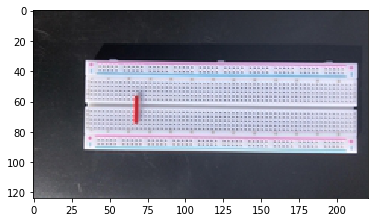

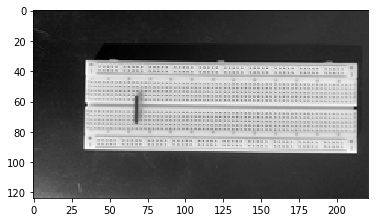

[[1.79105293e-08 5.93115274e-07 7.22562324e-06 3.23829967e-05
  5.33905355e-05 3.23829967e-05 7.22562324e-06 5.93115274e-07
  1.79105293e-08]
 [5.93115274e-07 1.96412803e-05 2.39279779e-04 1.07237757e-03
  1.76805171e-03 1.07237757e-03 2.39279779e-04 1.96412803e-05
  5.93115274e-07]
 [7.22562324e-06 2.39279779e-04 2.91502447e-03 1.30642333e-02
  2.15392793e-02 1.30642333e-02 2.91502447e-03 2.39279779e-04
  7.22562324e-06]
 [3.23829967e-05 1.07237757e-03 1.30642333e-02 5.85498315e-02
  9.65323526e-02 5.85498315e-02 1.30642333e-02 1.07237757e-03
  3.23829967e-05]
 [5.33905355e-05 1.76805171e-03 2.15392793e-02 9.65323526e-02
  1.59154943e-01 9.65323526e-02 2.15392793e-02 1.76805171e-03
  5.33905355e-05]
 [3.23829967e-05 1.07237757e-03 1.30642333e-02 5.85498315e-02
  9.65323526e-02 5.85498315e-02 1.30642333e-02 1.07237757e-03
  3.23829967e-05]
 [7.22562324e-06 2.39279779e-04 2.91502447e-03 1.30642333e-02
  2.15392793e-02 1.30642333e-02 2.91502447e-03 2.39279779e-04
  7.22562324e-06]
 [5.93

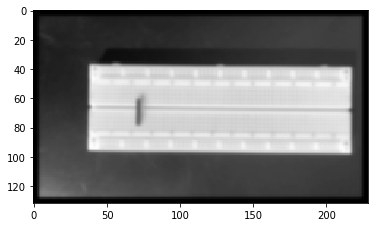

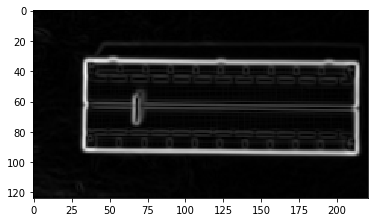

[[32, 34], [91, 33], [93, 212], [34, 213]]


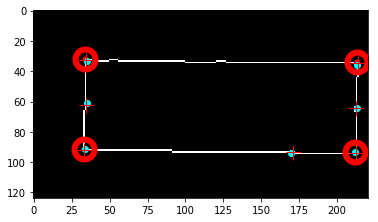

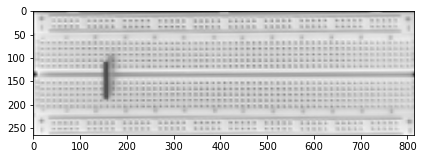

In [32]:
for num in range(1,2):
    print('num', num)
    create_gray_key_im(num)
    new_im = np.load("keyed_comp_as_arrs/npwarped_comp_key_gray_" + str(num) +".npy")
    imshow(new_im)